### Defining regions in the data with the Schaefer2018 100Parcels atlas combined with the Tian Subcortex 16Parcels atlas:

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import numpy as np
import os

data = nib.load("sleep_data\sub-01_task-rest_run-1_bold.nii.gz").get_fdata()
atlas = nib.load('sleep_data\Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz')

atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_labels = np.unique(atlas_data)
atlas_labels = atlas_labels[1:] # remove 0
atlas_labels = atlas_labels.astype(int)

data.shape, atlas_data.shape, atlas_labels.shape

if not os.path.exists('sleep_data/data_regions.csv'):
    data_region = np.zeros((data.shape[3], len(atlas_labels)))
    for j in tqdm(range(len(atlas_labels))):
        for k in range(data.shape[3]):
            data_region[k,j] = np.mean(data[:,:,:,k][atlas_data == atlas_labels[j]])

    df = pd.DataFrame(data_region)
    df.to_csv('data_regions.csv', index=False)
else:
    df = pd.read_csv('sleep_data/data_regions.csv')
    data_region = df.values

N_t, N_regions = data_region.shape
N_t, N_regions

ERROR! Session/line number was not unique in database. History logging moved to new session 1102


(286, 116)

### Filtering the signals with a bandpass filter:

In [2]:
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
# from seaborn import set_theme
# set_theme()

normalized = lambda x: x / np.sum(x)

nyquist = 0.5 * 1/2.1 # code from "proc_data.py"
low = 0.008 / nyquist
high = 0.09 / nyquist
b, a = butter(2, [low, high], btype='band')

data_filtered = np.zeros_like(data_region)
for j in range(116):
    data_filtered[:,j] = filtfilt(b, a, data_region[:,j])

s_series = data_filtered

### Computing the Hilbert transform and the phase of the filtered signals:

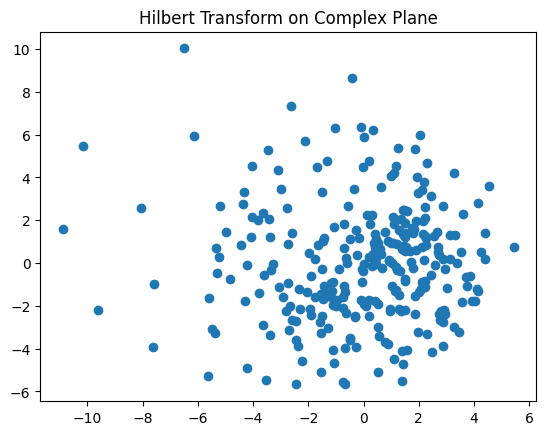

In [3]:
def angle(x): return np.arctan(np.imag(x) / np.real(x))

hilbert_complex = hilbert(s_series, axis=0)
phi_series = np.angle(hilbert_complex)

i = 0
plt.scatter(np.real(hilbert_complex[:,i]), np.imag(hilbert_complex[:,i]));
plt.title("Hilbert Transform on Complex Plane");

### Computing the instantaneous coherence matrix from the phase:

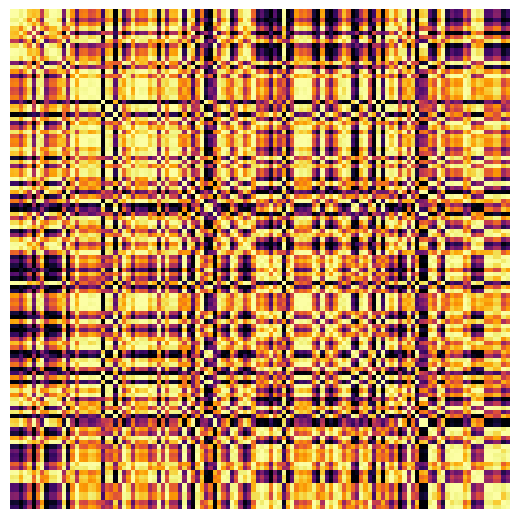

In [4]:
coh_map = lambda x: np.outer(np.cos(x), np.cos(x)) + np.outer(np.sin(x), np.sin(x))
coh_maps = np.array([coh_map(phi) for phi in phi_series])

def save_image(data, filename):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap="inferno")
    # fig.savefig(filename, dpi=data.shape[0]) 
    # plt.close(fig)

save_image(coh_maps[30], "")

# for i in range(3):
#     save_image(coh_maps[30+i], f"coh_map{30+i}.png")

### Computing the eigenvectors of the instantaneous coherence matrix:

Explained Variance
v1: 47.16%	 v2: 52.84%


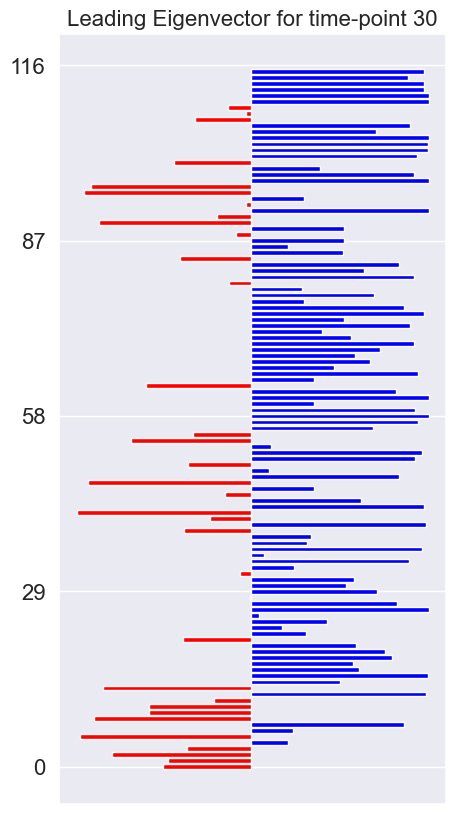

In [12]:
import seaborn as sns
sns.set_theme()
eigval, eigvec = np.linalg.eigh(coh_map(phi_series[30]))
l, v1, v2 = eigval[-2:], eigvec[:,-2:][:,0], eigvec[:,-2:][:,1]

# explained variance as percentage:
print(f"Explained Variance\nv1: {normalized(l)[0]:.2%}\t v2: {normalized(l)[1]:.2%}")

plt.figure(figsize=(5,10))
plt.barh(range(len(v2)), v1, color=["red" if v < 0 else "blue" for v in v1]);
plt.xticks([])
plt.yticks([0, 116//4, 116//2, 116//4*3, 116], fontsize=16)
plt.title("Leading Eigenvector for time-point 30", fontsize=16)
plt.show()

In [7]:
def leading_eigvec(A):
    eigvals, eigvecs = np.linalg.eigh(A)
    return eigvecs[:,-2:][:,eigvals[-2:].argmax()]

leading_eigvec(coh_map(phi_series[30])).shape

LEiDA_v = np.array([leading_eigvec(coh_map(phi_series[t])) for t in range(N_t)])
LEiDA_v.shape

(286, 116)

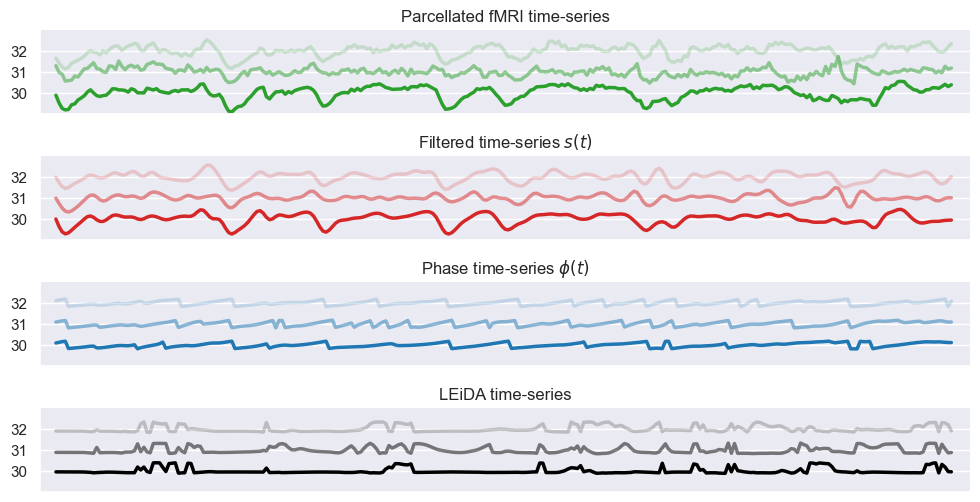

In [18]:
plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
i_init = 30

for i in range(3):
    for j,data in enumerate([data_region,s_series,phi_series,LEiDA_v]):
        data_slice = data[:,i_init+i] - data[:,i_init+i].mean() # standardized

        plt.subplot(4,1,1+j)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        step_size = 17 if j!=3 else 0.5
        plt.xticks([])
        plt.yticks(np.arange(step_size*3, step=step_size), range(i_init,i_init+3))
        plt.xlim(-5, N_t+5)
        plt.ylim(-step_size, step_size*3)
        plt.title(["Parcellated fMRI time-series", "Filtered time-series $s(t)$", "Phase time-series $\phi(t)$", "LEiDA time-series"][j])
        plt.plot(data_slice + i*step_size, alpha=[3/3, 2/4, 1/5][i], color=["tab:green", "tab:red", "tab:blue", 'black'][j], linewidth=2.5)
plt.show()